In [1]:
# Dependencies
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [15]:

# load password
from config import db_password

# Assign connection values
url = "finalproject.crrfdeawjuaz.us-east-1.rds.amazonaws.com"
port = "5432"
db_name = "tesla"

In [18]:
# Connect to the AWS database
from sqlalchemy import create_engine
db_string = f"postgresql://postgres:{db_password}@{url}:{port}/{db_name}"
engine = create_engine(db_string)
conn = engine.connect()

In [20]:
# read table daily values
df = pd.read_sql('SELECT * FROM "daily_values"', conn)
print(df.shape)
df.head()

(2821, 9)


,ticker,hdate,hopen,hhigh,hlow,hclose,hadjclose,hvolume,q_key
0,TSLA,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,None
1,TSLA,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,2010Q2
2,TSLA,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,None
3,TSLA,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,None
4,TSLA,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,None


In [30]:
# read table quarterly values
df2 = pd.read_sql('SELECT * FROM "quarterly_values"', conn)
print(df2.shape)
df2.head()

(50, 12)


,ticker,qdate,revenue,eps,net_income,gross_profit,operating_income,ebitda,shares,quarter,qyear,qlabel
0,TSLA,2021-06-30,11958000.0,1.02,1142000.0,2884000.0,1312000.0,1993000.0,1119000,Q2,2021,Q2-2021
1,TSLA,2021-03-31,10389000.0,0.39,438000.0,2215000.0,594000.0,1215000.0,1133000,Q1,2021,Q1-2021
2,TSLA,2020-12-31,10744000.0,0.25,270000.0,2066000.0,575000.0,1229000.0,1083000,Q4,2020,Q4-2020
3,TSLA,2020-09-30,8771000.0,0.27,300000.0,2063000.0,809000.0,1537000.0,1105000,Q3,2020,Q3-2020
4,TSLA,2020-06-30,6036000.0,0.10,104000.0,1267000.0,327000.0,894000.0,1036000,Q2,2020,Q2-2020


In [39]:
# read table yearly values
df3 = pd.read_sql('SELECT * FROM "yearly_values"', conn)
print(df3.shape)
df3.head()

(13, 9)


,ticker,yyear,revenue,eps,net_income,gross_profit,operating_income,ebitda,shares
0,TSLA,2020,31536000.0,0.64,690000.0,6630000.0,1994000.0,4496000.0,1083000
1,TSLA,2019,24578000.0,-0.98,-870000.0,4069000.0,-69000.0,2273000.0,887000
2,TSLA,2018,21461000.0,-1.14,-976000.0,4042000.0,-388000.0,1672000.0,853000
3,TSLA,2017,11759000.0,-2.37,-1962000.0,2223000.0,-1632000.0,95000.0,830000
4,TSLA,2016,7000000.0,-0.94,-675000.0,1599000.0,-667000.0,374000.0,721000


In [47]:
# read company values
df4 = pd.read_sql('SELECT * FROM "company"', conn)
print(df4.shape)
df4.head()

(1, 2)


,ticker_id,company_name
0,TSLA,"Tesla, Inc."


In [55]:
# read table common values - quarterly + share price
df5 = pd.read_sql('SELECT * FROM "common_values"', conn)
print(df5.shape)
df5.head()

(50, 14)


,ticker,qdate,revenue,eps,net_income,gross_profit,operating_income,ebitda,shares,quarter,qyear,qlabel,share_price,q_id
0,TSLA,2021-06-30,11958000.0,1.02,1142000.0,2884000.0,1312000.0,1993000.0,1119000,Q2,2021,Q2-2021,679.700,2021Q2
1,TSLA,2021-03-31,10389000.0,0.39,438000.0,2215000.0,594000.0,1215000.0,1133000,Q1,2021,Q1-2021,667.930,2021Q1
2,TSLA,2020-12-31,10744000.0,0.25,270000.0,2066000.0,575000.0,1229000.0,1083000,Q4,2020,Q4-2020,705.670,2020Q4
3,TSLA,2020-09-30,8771000.0,0.27,300000.0,2063000.0,809000.0,1537000.0,1105000,Q3,2020,Q3-2020,429.010,2020Q3
4,TSLA,2020-06-30,6036000.0,0.10,104000.0,1267000.0,327000.0,894000.0,1036000,Q2,2020,Q2-2020,215.962,2020Q2


In [64]:
df["hdate"] = pd.to_datetime(df["hdate"], infer_datetime_format=True)
df = df[["hdate", "hclose"]]

In [73]:
df = df.rename(columns={"hdate" : "ds", "hclose" : "y" })

In [87]:

model = Prophet()
model.fit(df)
predict = model.make_future_dataframe(periods=365*10)
forcast = model.predict(predict)
forcast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
6466,2031-09-04,4349.278420,3035.985606,5629.132271
6467,2031-09-05,4349.910466,3070.989323,5588.550540
6468,2031-09-06,4353.201419,3045.733577,5606.002680
6469,2031-09-07,4354.214616,3048.636749,5619.496233
6470,2031-09-08,4353.864053,3044.795724,5607.029081


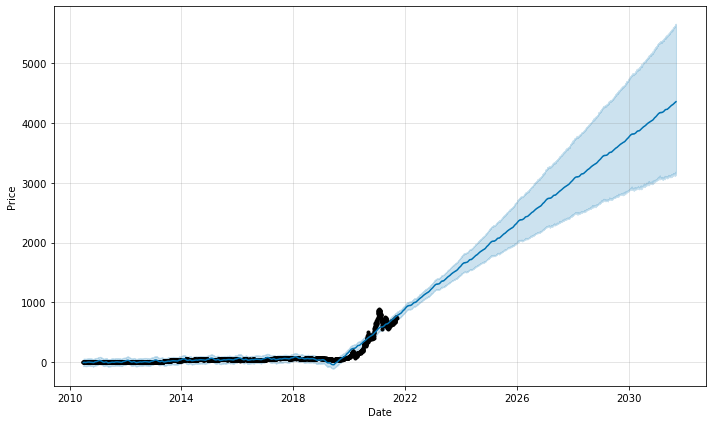

In [75]:
graph = model.plot(forcast, xlabel="Date", ylabel="Price")

In [88]:
forcast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-06-29,2.384897,-66.360512,52.169057,2.384897,2.384897,-7.202261,-7.202261,-7.202261,-0.329544,-0.329544,-0.329544,-6.872717,-6.872717,-6.872717,0.0,0.0,0.0,-4.817364
1,2010-06-30,2.394617,-62.352907,52.544517,2.394617,2.394617,-6.648090,-6.648090,-6.648090,-0.151469,-0.151469,-0.151469,-6.496621,-6.496621,-6.496621,0.0,0.0,0.0,-4.253473
2,2010-07-01,2.404337,-63.817124,58.969561,2.404337,2.404337,-6.804735,-6.804735,-6.804735,-0.676818,-0.676818,-0.676818,-6.127917,-6.127917,-6.127917,0.0,0.0,0.0,-4.400398
3,2010-07-02,2.414057,-67.211143,59.546222,2.414057,2.414057,-6.846320,-6.846320,-6.846320,-1.073974,-1.073974,-1.073974,-5.772346,-5.772346,-5.772346,0.0,0.0,0.0,-4.432263
4,2010-07-06,2.452938,-59.455275,62.475479,2.452938,2.452938,-4.921079,-4.921079,-4.921079,-0.329544,-0.329544,-0.329544,-4.591535,-4.591535,-4.591535,0.0,0.0,0.0,-2.468141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6466,2031-09-04,4349.946885,3035.985606,5629.132271,3051.904165,5598.997877,-0.668465,-0.668465,-0.668465,-0.676818,-0.676818,-0.676818,0.008353,0.008353,0.008353,0.0,0.0,0.0,4349.278420
6467,2031-09-05,4350.928075,3070.989323,5588.550540,3052.556211,5600.624541,-1.017609,-1.017609,-1.017609,-1.073974,-1.073974,-1.073974,0.056365,0.056365,0.056365,0.0,0.0,0.0,4349.910466
6468,2031-09-06,4351.909264,3045.733577,5606.002680,3053.208257,5602.189464,1.292154,1.292154,1.292154,1.195691,1.195691,1.195691,0.096463,0.096463,0.096463,0.0,0.0,0.0,4353.201419
6469,2031-09-07,4352.890454,3048.636749,5619.496233,3053.860303,5603.440296,1.324161,1.324161,1.324161,1.195692,1.195692,1.195692,0.128470,0.128470,0.128470,0.0,0.0,0.0,4354.214616


In [89]:
forcast = forcast.rename(columns={"ds" : "Date", "trend" : "Stock Price" })

In [90]:
forcast = forcast[["Date", "Stock Price"]]

In [91]:
forcast.tail(10)

,Date,Stock Price
6461,2031-08-30,4345.040936
6462,2031-08-31,4346.022126
6463,2031-09-01,4347.003316
6464,2031-09-02,4347.984505
6465,2031-09-03,4348.965695
6466,2031-09-04,4349.946885
6467,2031-09-05,4350.928075
6468,2031-09-06,4351.909264
6469,2031-09-07,4352.890454
6470,2031-09-08,4353.871644


In [92]:
forcast.to_csv('Teslapriceforcast.csv')